# SEDS 536 -- Homework 2

In [30]:
import cv2

import numpy as np
import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline

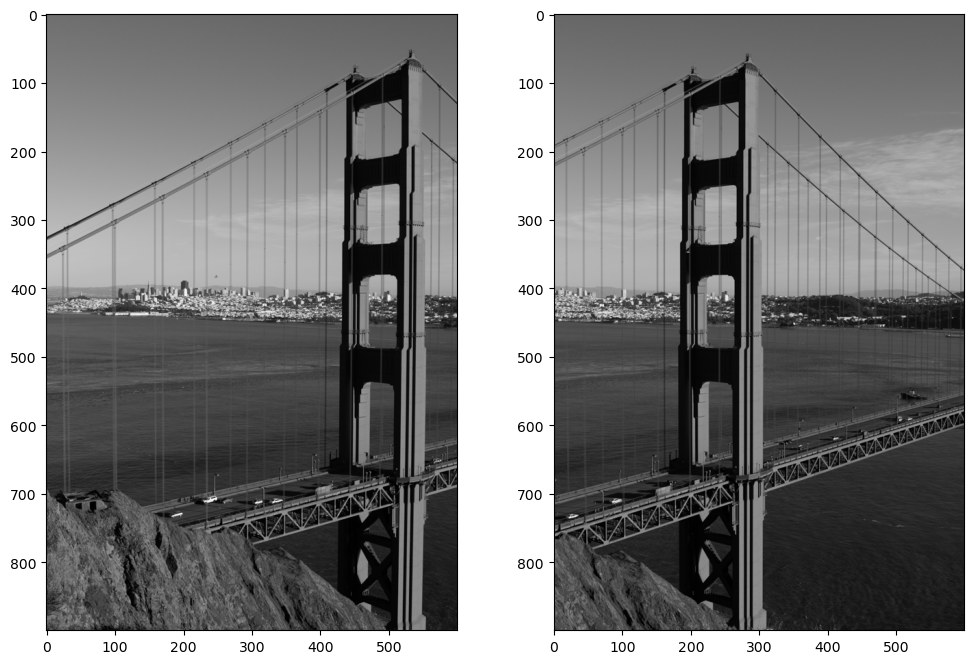

In [31]:
imgL = cv2.imread('goldengate-02.png')
imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
img_size = (imgL.shape[1], imgL.shape[0])
imgR = cv2.imread('goldengate-03.png')
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(imgL)
axes[1].imshow(imgR)

## Q1 Fast Keypoint Detection

Detect FAST keypoints in each image using the ORB feature detector and display them on the images. You may also compute the descriptors in this stage. Detect approximately 1000 features in each image using 5 levels. (You need to change the default parameters of the ORB feature detector.)

In [32]:
n_features = 1000
orb = cv2.ORB_create(n_features,nlevels=5)

In [33]:
keysL, descL = orb.detectAndCompute(grayL, None)
keysR, descR = orb.detectAndCompute(grayR, None)

len(keysL),len(keysR)

(1000, 1000)

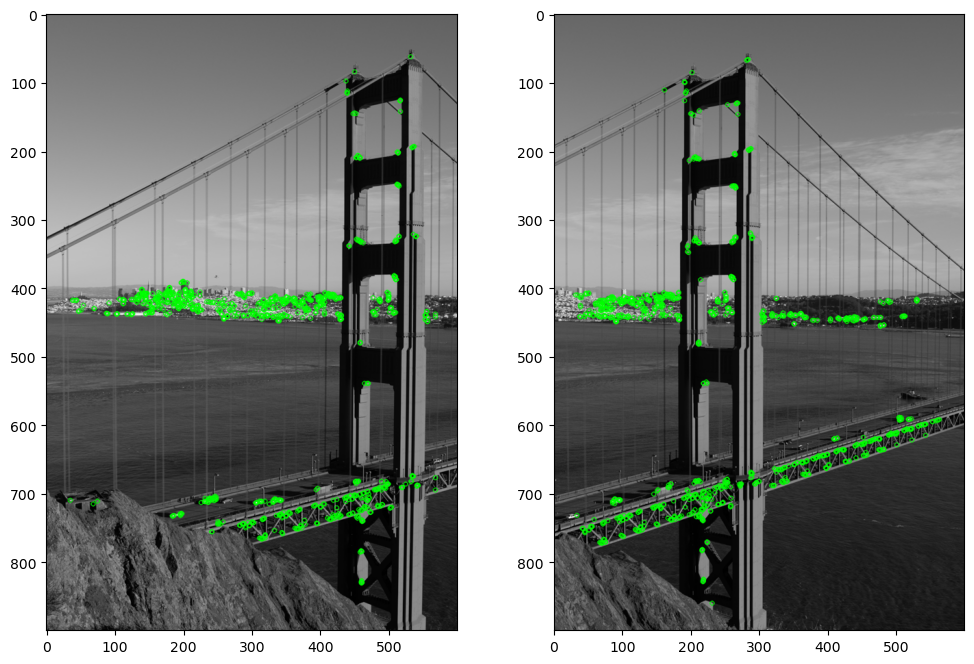

In [34]:
key_imgL = cv2.drawKeypoints(grayL, keysL, None, color=(0,255,0), flags=0)
key_imgR = cv2.drawKeypoints(grayR, keysR, None, color=(0,255,0), flags=0)

fig, axes = plt.subplots(1, 2, figsize=(12,8))
axes[0].imshow(key_imgL)
axes[1].imshow(key_imgR)

## Q2 Oriented BRIEF Keypoint Description and Matching

* Using the brute force matcher, match the detected FAST keypoints using the Hamming distance of their ORB descriptors.
* Calculate and display the minimum and maximum desriptor distances that you have obtained.
* Visualize the matches using OpenCV functions.

In [35]:
brute_force = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = brute_force.match(descL,descR)
distances = [match.distance for match in matches]
min_distance = min(distances)
max_distance = max(distances)
print(f"Minimum descriptor distance: {min_distance}")
print(f"Maximum descriptor distance: {max_distance}")

Minimum descriptor distance: 3.0
Maximum descriptor distance: 78.0


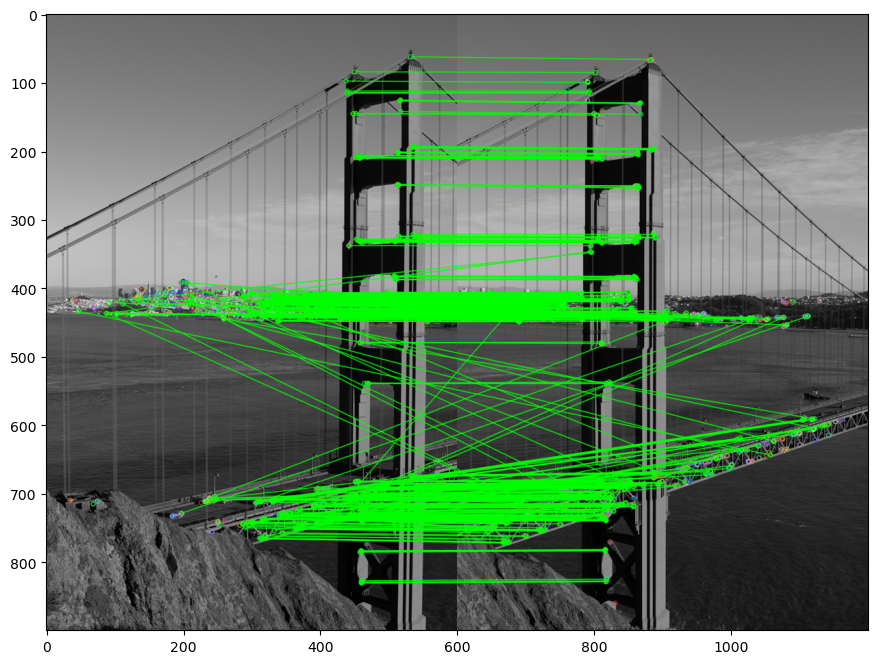

In [36]:
match_imgLR = cv2.drawMatches(grayL, keysL, grayR, keysR, matches, None, matchColor=(0, 255, 0))
fig, ax = plt.subplots(figsize=(12,8))
ax.imshow(match_imgLR)

### Good Mathces (Personal Curiosity)

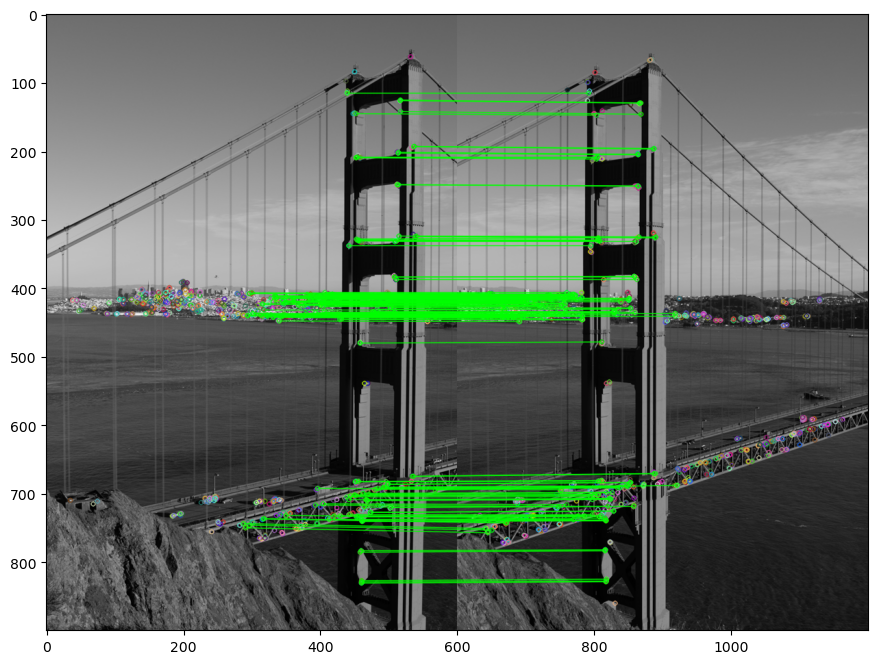

In [37]:
good_matches = [match for i, match in enumerate(matches[:-1]) if match.distance < 0.7 * matches[i + 1].distance]

match_imgLR = cv2.drawMatches(grayL, keysL, grayR, keysR, good_matches, None, matchColor=(0, 255, 0))
fig, ax = plt.subplots(figsize=(12, 8))
ax.imshow(match_imgLR)
plt.show()

## Q3 Robust Homography Estimation
* Calculate a homography between the images using RANSAC.
* Draw the image depicting the inlier matches between the images.
* Calculate and print the average distance between the original points in the right image and the transformed points from left to right using the calculated homography. Use only the points that are part of the inlier set. You can transform points yourseves or use the OpenCV function `perspectiveTransform` to transform points. Note that this function requires point arrays to be Nx1x2 form.

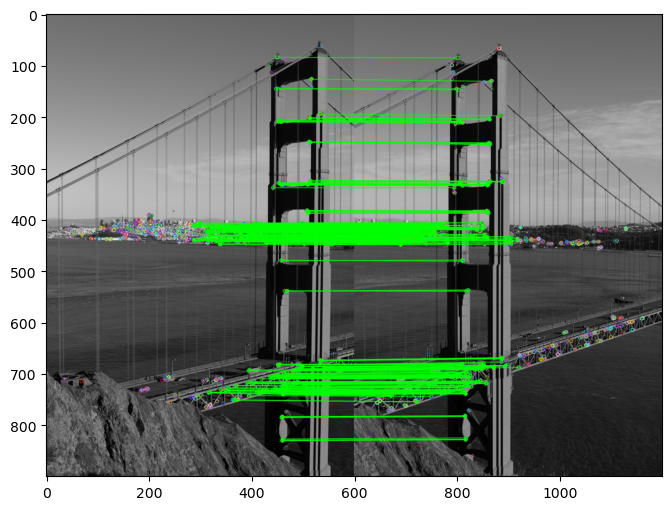

In [38]:
points_L = np.float32([keysL[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
points_R = np.float32([keysR[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(points_L, points_R, cv2.RANSAC)

inlier_matches_img = cv2.drawMatches(grayL, keysL, grayR, keysR, matches, None, matchColor=(0, 255, 0), matchesMask=mask.ravel())

plt.figure(figsize=(12, 6))
plt.imshow(inlier_matches_img)
plt.show()


In [41]:
transformed_points = cv2.perspectiveTransform(points_L, H)

inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] == 1]

total_distance = 0
count = 0

for i in range(len(inlier_matches)):
  if mask[i] == 1:
    distance = np.linalg.norm(points_R[i][0] - transformed_points[i][0])
    total_distance += distance
    count += 1

average_distance = total_distance/count if count > 0 else 0
print(f"Average distance between original points and transformed points: {average_distance}")


Average distance between original points and transformed points: 0.8036621234642536


In [42]:
H

array([[ 1.09167446e+00,  1.06442579e-02, -2.79704108e+02],
       [ 5.98585415e-02,  1.06453304e+00, -2.51607476e+01],
       [ 1.51374402e-04,  2.17591340e-07,  1.00000000e+00]])